In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd

%matplotlib inline
from pylab import mpl, plt
plt.style.use('seaborn')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'serif'

import csv, math, random
import tables as tb

import configparser
c = configparser.ConfigParser()
c.read('pyalgo.cfg')

import quandl as q
q.ApiConfig.api_key = c['quandl']['api_key']

KeyError: 'quandl'

---

https://www.quandl.com/data/BCHAIN/MKPRU-Bitcoin-Market-Price-USD<br>

---

In [26]:
def generate_sample_data (rows, cols, freq='1min'):
    ''' Function to generate sample financial data.
    
    Parameters
    ==========
    rows: int
        number of rows to generate
    cols: int
        number of columns to generate
    freq: str
        frequency string for DatetimeIndex
        
    Returns
    =======
    df: DataFrame
        DataFrame object with the sample data
    '''
    r = 0.05 # constant short rate
    sigma = 0.5 # volatility factor
    rows = int(rows)
    cols = int(cols)
    # generate a DatetimeIndex object given the frequency
    index = pd.date_range('2021-1-1', periods=rows, freq=freq)
    # determine time delta in year fractions
    dt = (index[1] - index[0]) / pd.Timedelta(value='365D')
    # generate column names
    columns = ['No%d' % i for i in range(cols)]
    # generate sample paths for geometric Brownian motion
    raw = np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * npr.standard_normal((rows, cols)), axis=0))
    # normalize the data to start at 100
    raw = raw / raw[0] * 100
    # generate the DataFrame object
    df = pd.DataFrame(raw, index=index, columns=columns)
    return df

---

# Ch. 1 Python and Algorithmic Trading

In [2]:
%%time
S0     = 100
r      = 0.05
T      = 1
sigma  = 0.2
values = []
for _ in range(1_000_000):
    ST = S0 * math.exp((r - 0.5 * sigma ** 2) * T + sigma * random.gauss(0, 1) * math.sqrt(T))
    values.append(ST)

CPU times: user 1.18 s, sys: 24.4 ms, total: 1.21 s
Wall time: 1.21 s


In [5]:
%%time
S0     = 100
r      = 0.05
T      = 1
sigma  = 0.2
ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * npr.standard_normal(1_000_000) * np.sqrt(T))

CPU times: user 39.6 ms, sys: 8.21 ms, total: 47.9 ms
Wall time: 46.8 ms


In [12]:
1.21e0 / 46.8e-3

25.85470085470085

In [18]:
d = q.get('BCHAIN/MKPRU')
d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4524 entries, 2009-01-02 to 2021-05-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   4524 non-null   float64
dtypes: float64(1)
memory usage: 70.7 KB


In [20]:
d['Value'].resample('A').last()

Date
2009-12-31        0.000000
2010-12-31        0.299998
2011-12-31        4.470000
2012-12-31       13.570000
2013-12-31      746.900000
2014-12-31      315.700000
2015-12-31      428.230000
2016-12-31      958.120000
2017-12-31    14165.575000
2018-12-31     3791.545833
2019-12-31     7219.600000
2020-12-31    28856.590000
2021-12-31    37280.350000
Freq: A-DEC, Name: Value, dtype: float64

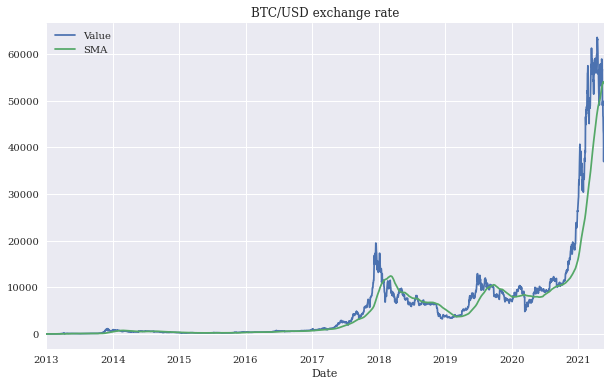

In [21]:
d['SMA'] = d['Value'].rolling(100).mean()
d.loc['2013-1-1':].plot(title='BTC/USD exchange rate', figsize=(10, 6));

---

# Ch. 3 Working with Financial Data

In [2]:
with open('data/AAPL.csv', 'r') as f:
    for _ in range(5):
        print(f.readline(), end='')

Date,HIGH,CLOSE,LOW,OPEN,COUNT,VOLUME
2020-04-01,248.72,240.91,239.13,246.5,460606.0,44054638.0
2020-04-02,245.15,244.93,236.9,240.34,380294.0,41483493.0
2020-04-03,245.7,241.41,238.9741,242.8,293699.0,32470017.0
2020-04-06,263.11,262.47,249.38,250.9,486681.0,50455071.0


In [12]:
data = pd.read_csv('data/AAPL.csv', index_col=0, parse_dates=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21 entries, 2020-04-01 to 2020-04-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    21 non-null     float64
 1   CLOSE   21 non-null     float64
 2   LOW     21 non-null     float64
 3   OPEN    21 non-null     float64
 4   COUNT   21 non-null     float64
 5   VOLUME  21 non-null     float64
dtypes: float64(6)
memory usage: 1.1 KB


In [16]:
data.to_excel('data/aapl.xlsx', 'AAPL')
data.to_json('data/aapl.json')

data_copy_1 = pd.read_excel('data/aapl.xlsx', 'AAPL', index_col=0)
display(data_copy_1.head())

data_copy_2 = pd.read_json('data/aapl.json')
display(data_copy_2.head())

,HIGH,CLOSE,LOW,OPEN,COUNT,VOLUME
Date,,,,,,
2020-04-01,248.72,240.91,239.1300,246.50,460606,44054638
2020-04-02,245.15,244.93,236.9000,240.34,380294,41483493
2020-04-03,245.70,241.41,238.9741,242.80,293699,32470017
2020-04-06,263.11,262.47,249.3800,250.90,486681,50455071
2020-04-07,271.70,259.43,259.0000,270.80,467375,50721831


,HIGH,CLOSE,LOW,OPEN,COUNT,VOLUME
2020-04-01,248.72,240.91,239.1300,246.50,460606,44054638
2020-04-02,245.15,244.93,236.9000,240.34,380294,41483493
2020-04-03,245.70,241.41,238.9741,242.80,293699,32470017
2020-04-06,263.11,262.47,249.3800,250.90,486681,50455071
2020-04-07,271.70,259.43,259.0000,270.80,467375,50721831


In [22]:
data = q.get('FSE/SAP_X', start_date='2018-1-1', end_date='2021-05-01')
vol = q.get('VOL/MSFT')
vol.iloc[:, :10].info()
vol[['IvMean30', 'IvMean60', 'IvMean90']].tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2018-01-02 to 2020-12-01
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Open                   408 non-null    float64
 1   High                   730 non-null    float64
 2   Low                    730 non-null    float64
 3   Close                  730 non-null    float64
 4   Change                 0 non-null      object 
 5   Traded Volume          684 non-null    float64
 6   Turnover               684 non-null    float64
 7   Last Price of the Day  0 non-null      object 
 8   Daily Traded Units     0 non-null      object 
 9   Daily Turnover         0 non-null      object 
dtypes: float64(6), object(4)
memory usage: 62.7+ KB


In [37]:
%time data = generate_sample_data(rows=5e6, cols=10).round(4)
h5 = pd.HDFStore('data/data.h5', 'w')
%time h5['data'] = data
h5.close()

CPU times: user 3.34 s, sys: 623 ms, total: 3.96 s
Wall time: 3.96 s
CPU times: user 313 ms, sys: 442 ms, total: 755 ms
Wall time: 1.18 s


In [39]:
%time data = generate_sample_data(rows=5e6, cols=10).round(4)
%time data.to_hdf('data/data.h5', 'data', format='table')
%time data_copy = pd.read_hdf('data/data.h5', 'data')

CPU times: user 3.38 s, sys: 735 ms, total: 4.11 s
Wall time: 4.12 s
CPU times: user 2.93 s, sys: 390 ms, total: 3.32 s
Wall time: 3.35 s
CPU times: user 209 ms, sys: 195 ms, total: 404 ms
Wall time: 408 ms


In [44]:
h5 = tb.open_file('data/data.h5', 'r')
h5
h5.root.data.table[:3]
h5.close()

---

# Ch. 4 Mastering Vectorized Backtesting

In [53]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [54]:
data = pd.DataFrame(raw['EUR='])
data = data.rename(columns={'EUR=': 'price'})
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


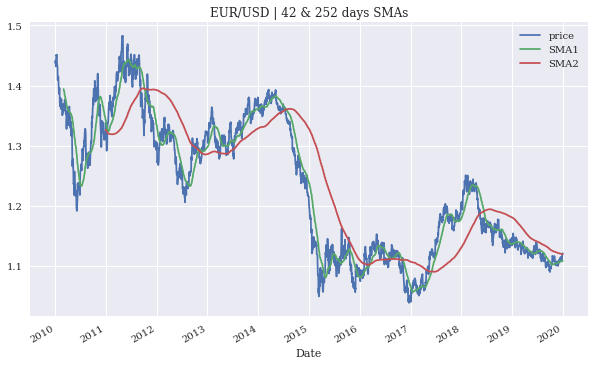

In [55]:
data['SMA1'] = data['price'].rolling(42).mean()
data['SMA2'] = data['price'].rolling(252).mean()
data.plot(title='EUR/USD | 42 & 252 days SMAs', figsize=(10, 6));

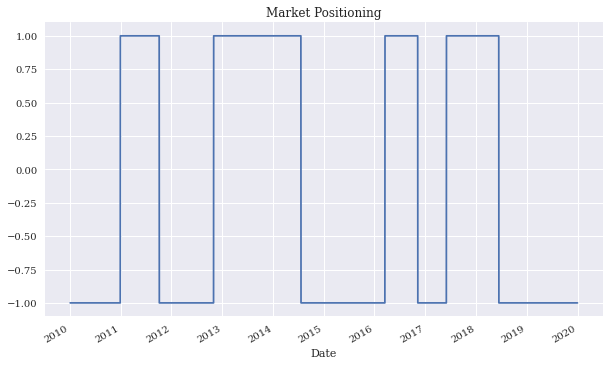

In [56]:
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
data['position'].plot(ylim=[-1.1, 1.1], title='Market Positioning', figsize=(10, 6));

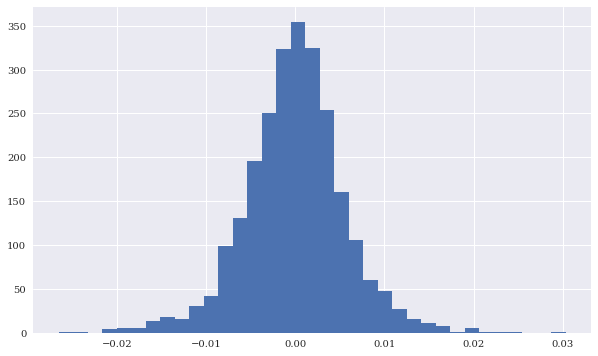

In [57]:
data['returns'] = np.log(data['price'] / data['price'].shift(1))
data['returns'].hist(bins=35, figsize=(10, 6));

In [58]:
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].sum()

returns    -0.251186
strategy    0.327576
dtype: float64

In [59]:
data[['returns', 'strategy']].sum().apply(np.exp)

returns     0.777878
strategy    1.387600
dtype: float64

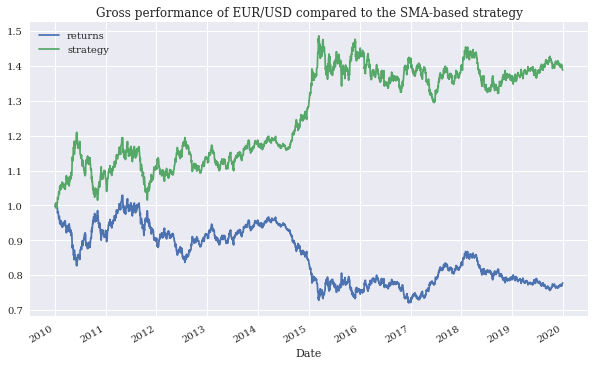

In [66]:
data[['returns', 'strategy']].cumsum().apply(np.exp).plot(title='Gross performance of EUR/USD compared to the SMA-based strategy', figsize=(10, 6));